# 6회차: DNN을 활용한 집값 예측을 위한 모델 최적화

In [ ]:
# 수치 계산을 위한 핵심 라이브러리 (배열, 벡터, 행렬 연산 등)
import numpy as np
# 딥러닝 모델 구축 및 학습을 위한 TensorFlow 프레임워크
import tensorflow as tf
# 데이터 시각화를 위한 라이브러리 (선 그래프, 산점도 등)
import matplotlib.pyplot as plt

# TensorFlow에서 제공하는 Boston 주택 가격 데이터셋 로드
from tensorflow.keras.datasets import boston_housing
# Z-점수 정규화를 위한 전처리 도구 (평균 0, 표준편차 1로 스케일링)
from sklearn.preprocessing import StandardScaler
# 회귀 성능 평가 지표 (평균제곱오차, 평균절대오차 계산용)
from sklearn.metrics import mean_squared_error, mean_absolute_error
# 학습/검증 데이터셋 분할 함수 (train/test 나누기)
from sklearn.model_selection import train_test_split

# 1. Boston Housing 데이터 로드 (이미 train/test로 나뉘어 있음)
(x_train_full, y_train_full), (x_test, y_test) = boston_housing.load_data()

# 2. Z-점수 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train_full)
X_test_scaled = scaler.transform(x_test)

# 3. 학습 데이터를 다시 학습/검증으로 분할 (학습:검증 = 80:20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train_full, test_size=0.2, random_state=42)

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [57]:
# 수치 계산을 위한 핵심 라이브러리 (배열, 벡터, 행렬 연산 등)
import numpy as np
# 딥러닝 모델 구축 및 학습을 위한 TensorFlow 프레임워크
import tensorflow as tf
# 데이터 시각화를 위한 라이브러리 (선 그래프, 산점도 등)
import matplotlib.pyplot as plt

# TensorFlow에서 제공하는 Boston 주택 가격 데이터셋 로드
from tensorflow.keras.datasets import boston_housing
# Z-점수 정규화를 위한 전처리 도구 (평균 0, 표준편차 1로 스케일링)
from sklearn.preprocessing import StandardScaler
# 회귀 성능 평가 지표 (평균제곱오차, 평균절대오차 계산용)
from sklearn.metrics import mean_squared_error, mean_absolute_error
# 학습/검증 데이터셋 분할 함수 (train/test 나누기)
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. 데이터 로드
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

# 2. 표준화 (StandardScaler 사용)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [58]:
# 3. 간단한 데이터 증강 (Gaussian Noise)
def augment_data(X, y, noise_std=0.02):
    noise = np.random.normal(0, noise_std, X.shape)
    X_aug = X + noise
    y_aug = y.copy()
    return np.concatenate([X, X_aug], axis=0), np.concatenate([y, y_aug], axis=0)

print(f'데이터 증강 전: {x_train_scaled.shape}')
x_train_aug, y_train_aug = augment_data(x_train_scaled, y_train, noise_std=0.02)
print(f'데이터 증강 후: {x_train_aug.shape}')

데이터 증강 전: (404, 13)
데이터 증강 후: (808, 13)


In [91]:
# 4. 학습/검증 데이터 분리 (80% 학습, 20% 검증)
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_aug, y_train_aug, test_size=0.2, random_state=42
)

# 5. 모델 정의
def build_model():
    model = Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(64, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        ReLU(),

        Dense(32, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        ReLU(),

        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# 6. 학습률 조정 콜백 정의
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss', # 관찰할 지표: 검증 손실(val_loss)
                            # 이 값이 줄어들지 않으면 학습률을 감소시킴
        factor=0.4,         # 학습률 감소 계수 (곱하기로 적용)
                            # 현재 학습률에 0.4를 곱해서 감소시킴
                            # 예: 0.001 → 0.0004
        patience=10,        # 개선이 없더라도 몇 번의 epoch 동안 기다릴지 설정
                            # 여기선 10번 연속 개선이 없으면 학습률을 줄임
        verbose=1,          # 학습률이 줄어들 때마다 메시지를 출력함
                            # 0이면 조용하게 처리되고, 1이면 로그를 출력함
        min_lr=1e-8         # 학습률이 줄어들 수 있는 최소 한계 설정
                            # 이 값보다 낮아지지 않게 막아줌
    ),
    EarlyStopping(
        # monitor='val_mae',       # 검증 평균절대오류(val_mae)를 모니터링 대상으로 지정
        monitor='val_loss',        # 검증 손실(val_loss)를 모니터링 대상으로 지정
        patience=40,               # 40 epoch 동안 개선되지 않으면 학습 중단
        restore_best_weights=True, # 가장 성능이 좋았던 시점의 가중치로 복원
        verbose=1                  # 조기 종료 발생 시 메시지를 출력
    )
]

# 7. 모델 학습
model = build_model()
history = model.fit(
    x_train_final, y_train_final,   # 훈련 데이터셋, 증강 포함
    validation_data=(x_val, y_val), # 검증 데이터셋
    epochs = 300,                   # 총 300번 훈련 반복
    batch_size = 32,    # 가중치 조정하는 학습 배치 크기 32
    verbose = 1,        # 과정 보이기
    callbacks=callbacks # 학습률 조정 콜백 (ReduceLROnPlateau)
)

Epoch 1/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 572.1382 - mae: 22.2579 - val_loss: 587.5027 - val_mae: 22.5729 - learning_rate: 0.0010
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 550.4459 - mae: 21.9504 - val_loss: 568.0424 - val_mae: 22.2661 - learning_rate: 0.0010
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 519.7371 - mae: 21.3531 - val_loss: 547.3174 - val_mae: 21.9117 - learning_rate: 0.0010
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 493.2278 - mae: 20.8494 - val_loss: 521.3653 - val_mae: 21.4686 - learning_rate: 0.0010
Epoch 5/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 494.2695 - mae: 20.8513 - val_loss: 493.0262 - val_mae: 20.9723 - learning_rate: 0.0010
Epoch 6/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 469.6358 - mae: 20.5639 - val_loss: 462.4197 - val_mae: 20.4067 - learning_rate: 0.0010
Epoch 7/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 463.1881 - mae: 20.4660 - val_loss: 426.1389 - val_mae: 1

In [92]:
# 7. 테스트셋 평가
y_pred = model.predict(x_test_scaled).reshape(-1)
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

print("\n최종 테스트셋 평가 결과:")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

최종 테스트셋 평가 결과:
Test MAE: 2.2715
Test RMSE: 3.3432


In [83]:
# 8. 성능 평가 (RMSE, MAE)
y_pred = model.predict(x_test_scaled).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [84]:
# 소숫점 아래 2자리까지만 출력 설정
np.set_printoptions(precision=2)
print(y_test[:10]) # 잎 부분 10개의 정답 데이터
print(y_pred[:10]) # 잎 부분 10개의 예측 데이터

[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]
[ 9.27 19.25 22.15 32.08 22.8  24.83 30.43 21.22 19.54 20.72]


In [85]:
# 9. 회귀 성능 평가 지표 (평균제곱오차, 평균절대오차 계산용)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

RMSE: 3.518
MAE: 2.309


In [86]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

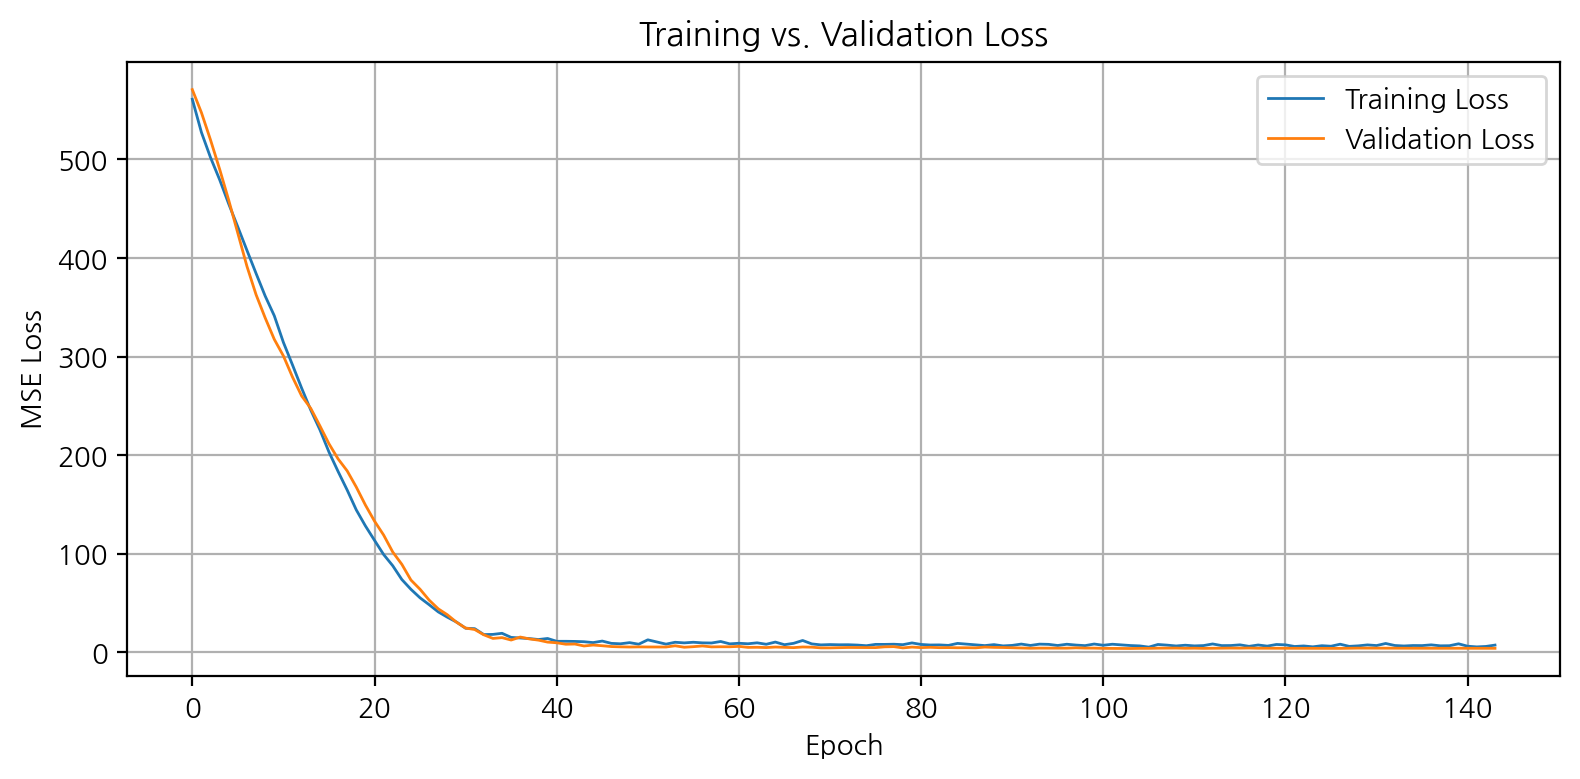

In [87]:
# 10. 학습/검증 손실 시각화
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

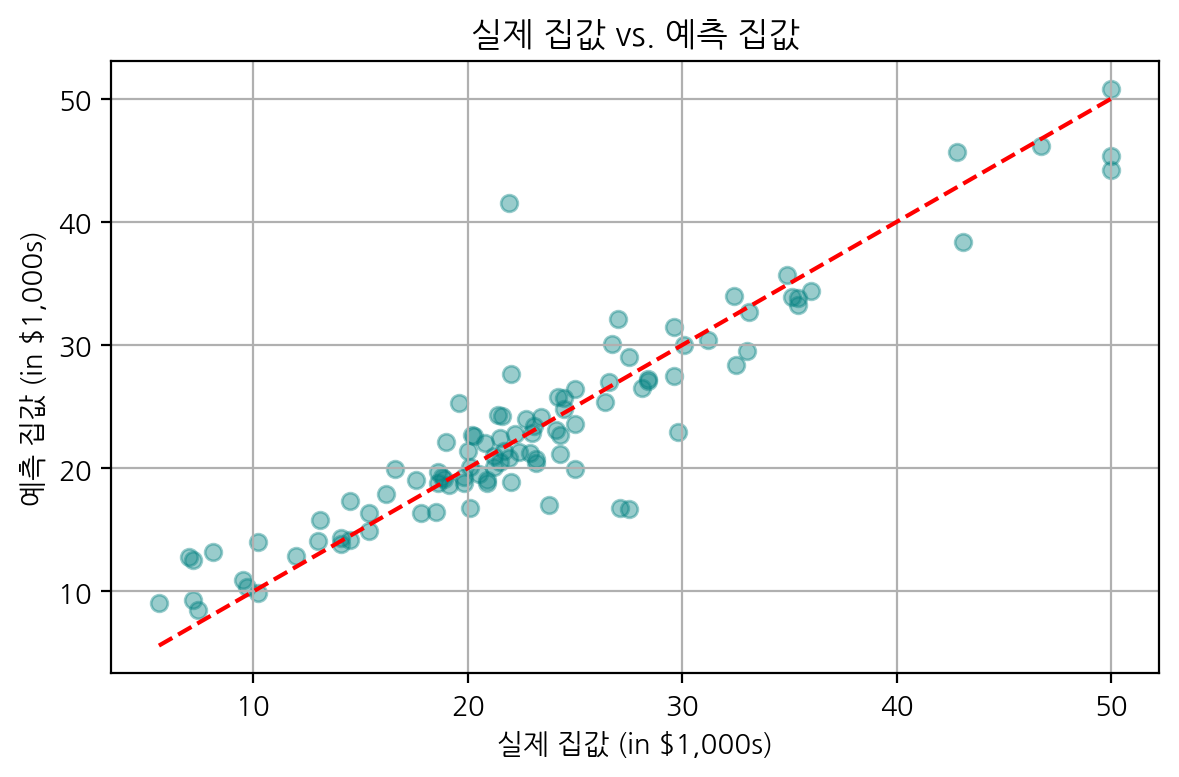

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # y = x 선
plt.xlabel('실제 집값 (in $1,000s)')
plt.ylabel('예측 집값 (in $1,000s)')
plt.title('실제 집값 vs. 예측 집값')
plt.grid(True)
plt.tight_layout()
plt.show()

### 심화 학습

In [93]:
import numpy as np

X = np.array([[1.0, 2.0], [3.0, 4.0]])
noise_std = 0.1
noise = np.random.normal(0, noise_std, X.shape)

print("원본 X:\n", X)
print("노이즈:\n", noise)
print("노이즈 더한 X:\n", X + noise)

원본 X:
 [[1. 2.]
 [3. 4.]]
노이즈:
 [[ 0.07 -0.01]
 [ 0.   -0.24]]
노이즈 더한 X:
 [[1.07 1.99]
 [3.   3.76]]


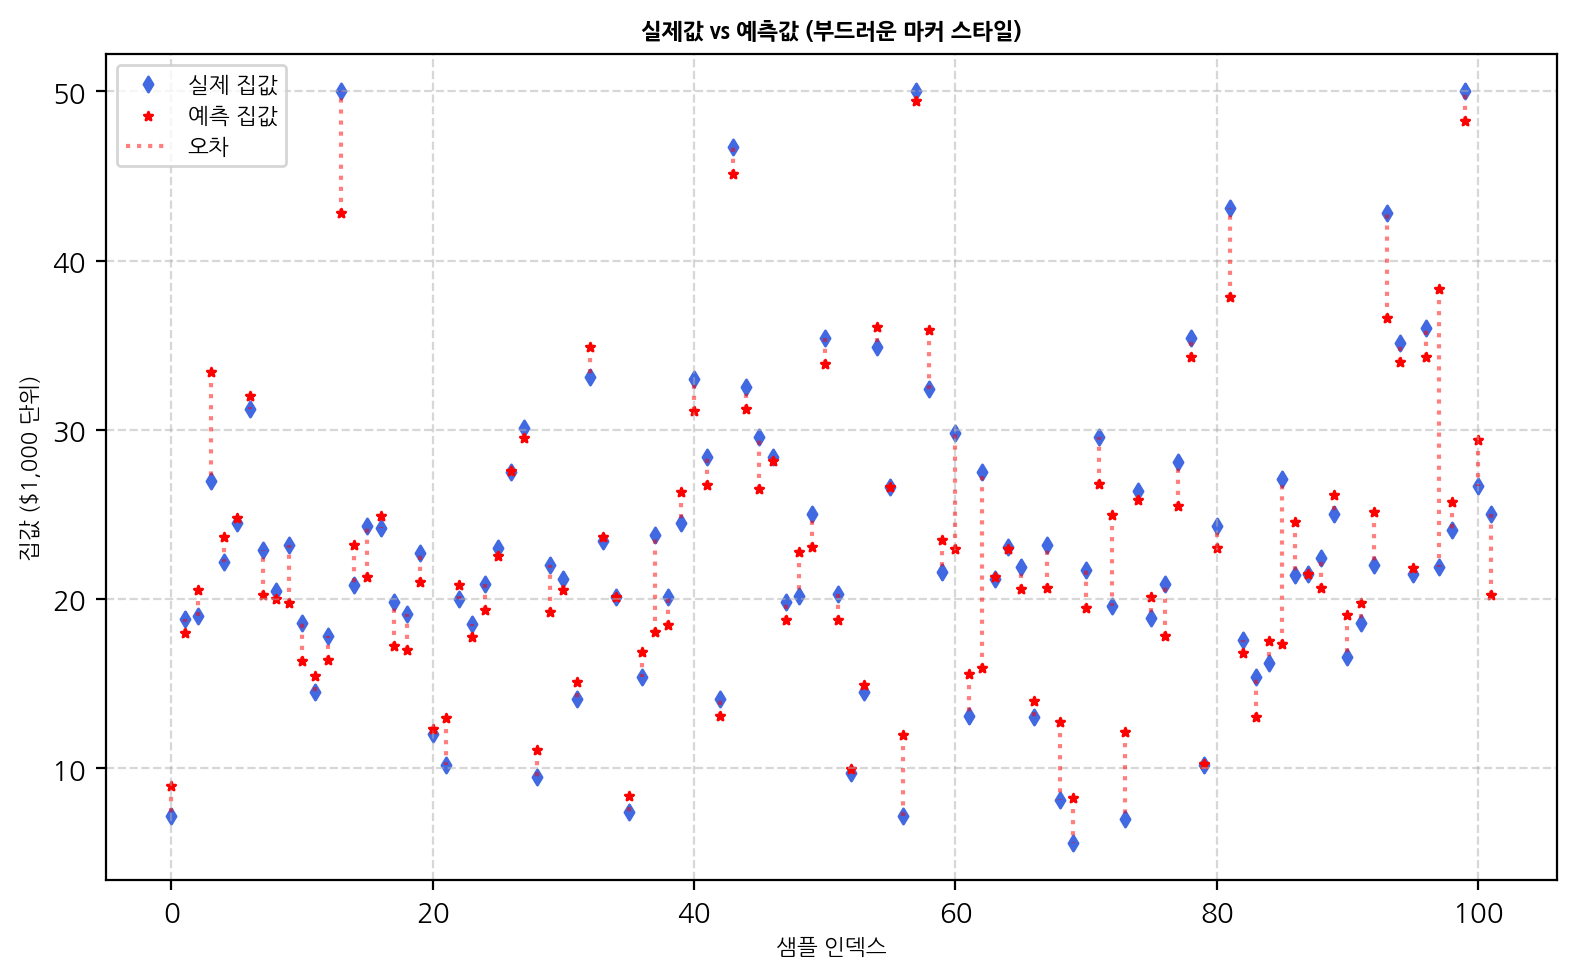

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 오차 계산
errors = np.abs(y_test - y_pred)

# 시각화 시작
plt.figure(figsize=(8, 5))

# 실제값 (다이아몬드 마커, 파란색)
plt.scatter(range(len(y_test)), y_test, label='실제 집값', color='royalblue', marker='d', s=15)

# 예측값 (위쪽 삼각형 마커, 주황색)
plt.scatter(range(len(y_pred)), y_pred, label='예측 집값', color='red', marker='*', s=10)

# 오차 (붉은 점선)
plt.vlines(range(len(y_test)), y_pred, y_test, colors='red', linestyles='dotted', alpha=0.5, label='오차')

# 그래프 설정
plt.xlabel('샘플 인덱스', fontsize=8)
plt.ylabel('집값 ($1,000 단위)', fontsize=8)
plt.title('실제값 vs 예측값 (부드러운 마커 스타일)', fontsize=8, fontweight='bold')
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


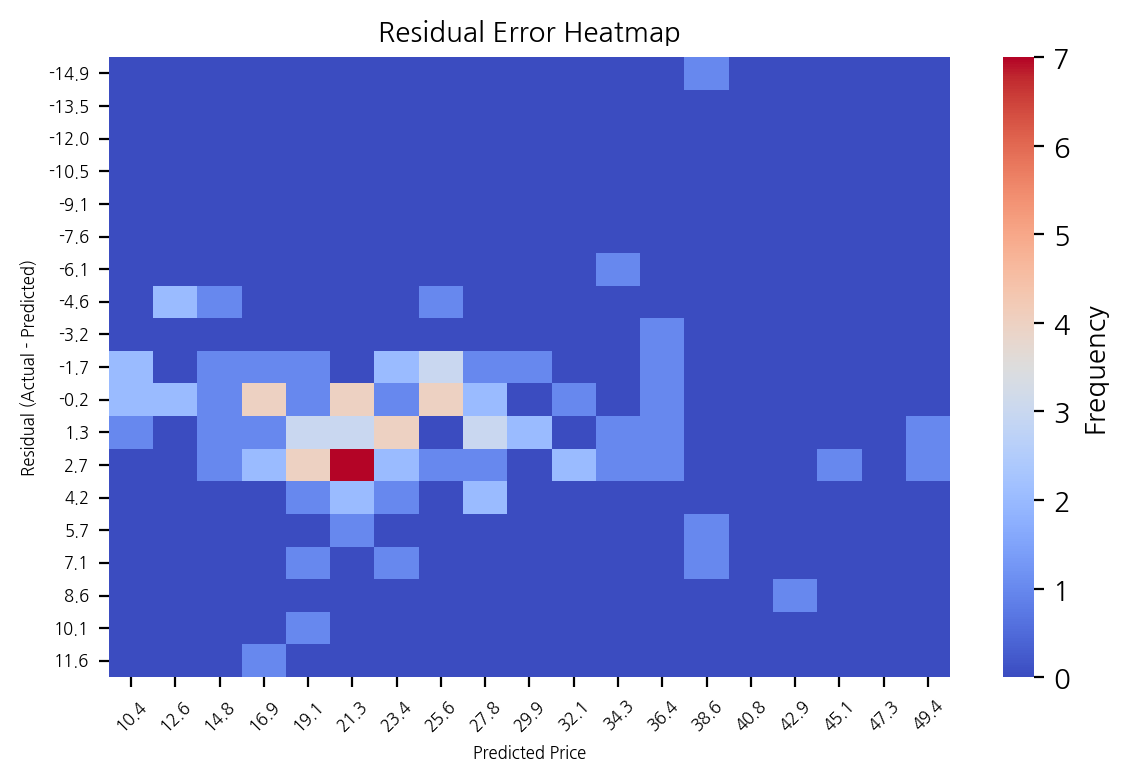

In [40]:
# 3. 잔차 계산
residuals = y_test - y_pred

# 4. 2D 히트맵용 binning
bins_pred = np.linspace(min(y_pred), max(y_pred), 20)
bins_resid = np.linspace(min(residuals), max(residuals), 20)
heatmap_data, xedges, yedges = np.histogram2d(y_pred, residuals, bins=[bins_pred, bins_resid])

# 5. 히트맵 시각화 (폰트 크기 축소 적용)
plt.figure(figsize=(6, 4))
sns.heatmap(
    heatmap_data.T,
    xticklabels=np.round(xedges[1:], 1),
    yticklabels=np.round(yedges[1:], 1),
    cmap='coolwarm',
    cbar_kws={'label': 'Frequency'}
)

plt.xlabel("Predicted Price", fontsize=6)
plt.ylabel("Residual (Actual - Predicted)", fontsize=6)
plt.title("Residual Error Heatmap", fontsize=10)

plt.xticks(fontsize=6, rotation=45)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

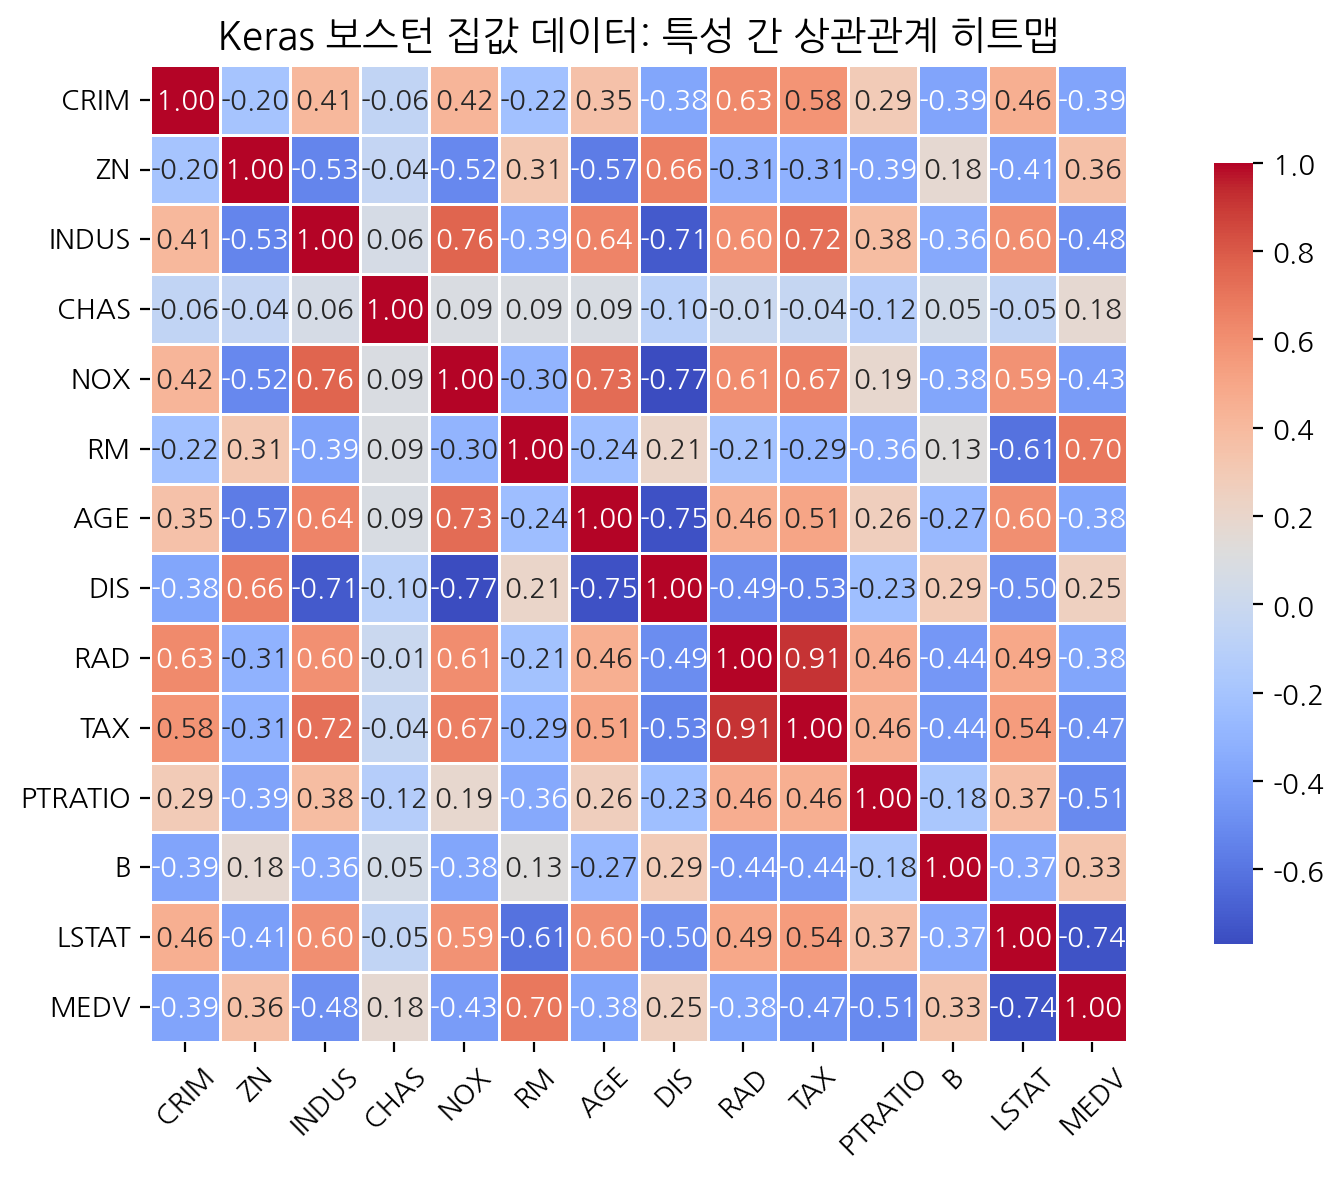

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import boston_housing

# 1. 데이터 로드 (훈련 + 테스트 합치기)
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
x_all = np.concatenate((x_train, x_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# 2. 컬럼 이름 정의 (Keras는 feature 이름을 제공하지 않음)
feature_names = [
    'CRIM',   # 범죄율
    'ZN',     # 25,000 평방피트 이상 주거지역 비율
    'INDUS',  # 비소매 상업 지역 비율
    'CHAS',   # 찰스강 인접 여부
    'NOX',    # 일산화질소 농도
    'RM',     # 방 개수
    'AGE',    # 1940년 이전에 지어진 주택 비율
    'DIS',    # 직업센터 거리
    'RAD',    # 고속도로 접근성 지수
    'TAX',    # 재산세율
    'PTRATIO',# 학생-교사 비율
    'B',      # 흑인 인구 비율
    'LSTAT'   # 저소득층 비율
]

# 3. 데이터프레임 생성
df = pd.DataFrame(x_all, columns=feature_names)
df['MEDV'] = y_all  # 타깃 추가

# 4. 상관관계 히트맵
plt.figure(figsize=(9, 6))
sns.heatmap(df.corr(),
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title("Keras 보스턴 집값 데이터: 특성 간 상관관계 히트맵", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 종료